In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
edata = pd.read_csv("DataE.csv")
sdata = pd.read_csv("DataS.csv")

In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

In [4]:
X = edata.drop(["EM","WPM","ID"],axis=1)
# X = sdata.drop(["EM","WPM","ID"],axis=1)
y = edata["EM"]

In [5]:
X_train, X_test , y_train, y_test = train_test_split( X , y, test_size = 0.2, random_state = 42)

In [6]:
n_data,n_features = X_train.shape

In [7]:
X_train

,2549.999982425943,2541.1764576690834,2532.413778802841,2523.711330475089,2515.0684820358,2506.4846350096395,2497.959175659239,2489.4915218146975,2481.0810760850013,2472.7272720573364,...,1372.7103861776873,1370.1493587103473,1367.5978712645606,1365.0558671626618,1362.5232970892694,1360.0001051783643,1357.4862428673305,1354.9816550870514,1352.4862940136636,1350.000105360531
338,0.453266,0.447556,0.443219,0.442089,0.444962,0.451623,0.460818,0.470829,0.480787,0.490950,...,4.493286,4.610909,4.712629,4.802691,4.887575,4.970202,5.051205,5.130048,5.206762,5.283184
828,0.422249,0.423579,0.423810,0.424008,0.425051,0.427045,0.429420,0.431821,0.434769,0.439593,...,4.223375,4.340157,4.438268,4.511969,4.568698,4.620260,4.680339,4.759134,4.859613,4.976265
2,0.311741,0.306910,0.304235,0.304210,0.306666,0.311049,0.316748,0.323522,0.331775,0.342162,...,2.603714,2.676055,2.743138,2.801392,2.848467,2.883821,2.910470,2.934305,2.962689,3.002778
296,0.447063,0.443690,0.440125,0.436174,0.432170,0.429170,0.428681,0.431612,0.438325,0.448483,...,3.047097,3.152145,3.244301,3.320230,3.383213,3.436762,3.484726,3.530582,3.577587,3.629325
660,0.511618,0.507955,0.503491,0.500634,0.501133,0.505387,0.512124,0.519099,0.524729,0.528758,...,3.780122,3.904025,4.029393,4.148284,4.254123,4.343427,4.416653,4.477553,4.531801,4.585155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.351665,0.348241,0.346593,0.347452,0.350890,0.356377,0.363002,0.370131,0.378022,0.387623,...,3.300470,3.394419,3.490787,3.587925,3.677594,3.750718,3.802967,3.837990,3.866852,3.904022
106,0.338662,0.340767,0.338373,0.332951,0.326942,0.322924,0.322848,0.326951,0.334672,0.345141,...,3.563824,3.644180,3.734126,3.835602,3.940307,4.038260,4.122256,4.190964,4.249052,4.304700
270,0.443889,0.448665,0.453280,0.457705,0.462069,0.466402,0.470681,0.475234,0.481107,0.490037,...,4.666995,4.775442,4.885468,4.997283,5.110398,5.225794,5.346485,5.476314,5.617600,5.769053
435,0.571222,0.571243,0.570075,0.570160,0.573264,0.579716,0.588271,0.597113,0.605461,0.613984,...,4.669743,4.769051,4.858791,4.938518,5.011898,5.084988,5.166632,5.265394,5.385729,5.525495


In [8]:
from scipy.signal import savgol_filter
from sklearn.base import BaseEstimator, TransformerMixin

class Savgol(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self, window_length=5, polyorder=2, deriv=0, wavemin=950, wavemax=1530):# 
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv
        self.wavemin = wavemin
        self.wavemax = wavemax
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # colnames = [str(x) for x in range(self.wavemin, self.wavemax+1,2)]
        colnames = X.columns
        df = X[colnames].copy(deep=True)
        toreturn = df.apply(savgol_filter, args=(self.window_length, self.polyorder, self.deriv,1. , 0, 'nearest'), axis=1, raw=True, result_type='broadcast')
        return toreturn

params={'window_length':27, 'polyorder':2, 'deriv':2, 'wavemin':50, 'wavemax':3530}
savgol = Savgol(**params)
savgol.fit_transform(X_train).shape

(677, 257)

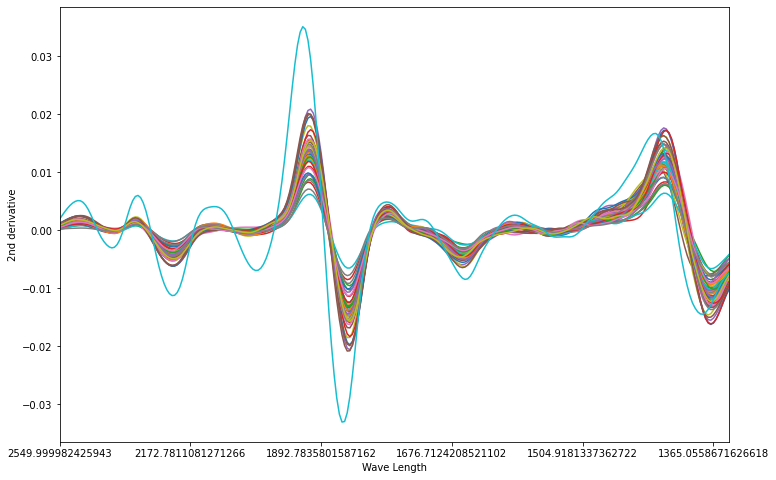

In [9]:
df = savgol.transform(X_train)
df.head(50).T.plot(legend=None, figsize=(12,8))
#plt.title('Spectras - 1rst derivative')
plt.xlabel('Wave Length') #,fontname="Times New Roman", fontsize=18
plt.ylabel('2nd derivative')
#plt.yticks(fontname="Times New Roman", fontsize=18)
#plt.xticks(fontname="Times New Roman", fontsize=18)

# plt.xticks(np.arange(len(df.columns)), [v if (int(v) % 100 == 0) or k==0 or k==len(df.columns)-1 else '' for (k,v) in enumerate(df.columns)], rotation=90)
plt.savefig('genera-rawSpectras-2ndderivative.png')
plt.show()

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_union

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

In [12]:
lrpipelist1 = [#
               ('savgol', savgol),
               ('scaler', scaler),
               ('pca', pca)] #
pipe1 = Pipeline(lrpipelist1)

In [13]:
pipe1.fit_transform(X_train).shape

(677, 257)

In [14]:
from sklearn.linear_model import ElasticNet
elnet = ElasticNet(random_state=0, max_iter=10000)

In [15]:
listpipereg = [('pipe1', pipe1), ('elnet', elnet)] #
pipereg = Pipeline(listpipereg)

In [16]:
pipereg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pipe1',
                 Pipeline(memory=None,
                          steps=[('savgol',
                                  Savgol(deriv=2, polyorder=2, wavemax=3530,
                                         wavemin=50, window_length=27)),
                                 ('scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=None, random_state=None,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('elnet',
                 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=10000, normalize=False,
       

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False, random_state=47)

In [18]:
rmsecv = []
components = [2,5,]
components.extend(np.arange(10,60+1,5))
alpha_opt = []
l1_ratio_opt = []

for component in components:
    pipe1.set_params(pca__n_components=component)
    Xtrans = pipe1.fit_transform(X_train)
    
    elnet = ElasticNet(random_state=0)
    
    alpha_range = np.logspace(-3, 0, 11)
    l1_ratio_range = np.linspace(0.0001, 1, 11)
    param_grid = dict(alpha=alpha_range, l1_ratio=l1_ratio_range)
    
    gridpca = GridSearchCV(elnet, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='neg_mean_squared_error')
    gridpca.fit(Xtrans, y_train)
    
    alpha_opt.append(gridpca.best_params_['alpha'])
    l1_ratio_opt.append(gridpca.best_params_['l1_ratio'])
    
    elnet = ElasticNet(random_state=0, **gridpca.best_params_)
    
    
    #preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf, n_jobs=-2)
    preds = gridpca.predict(pipe1.transform(X_test))
    score = mean_squared_error(y_test , preds)
    
    rmsecv.append(score)

/home/william/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/william/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/william/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/william/anaconda3/lib/python3.7/site-packages/sklearn/model_s

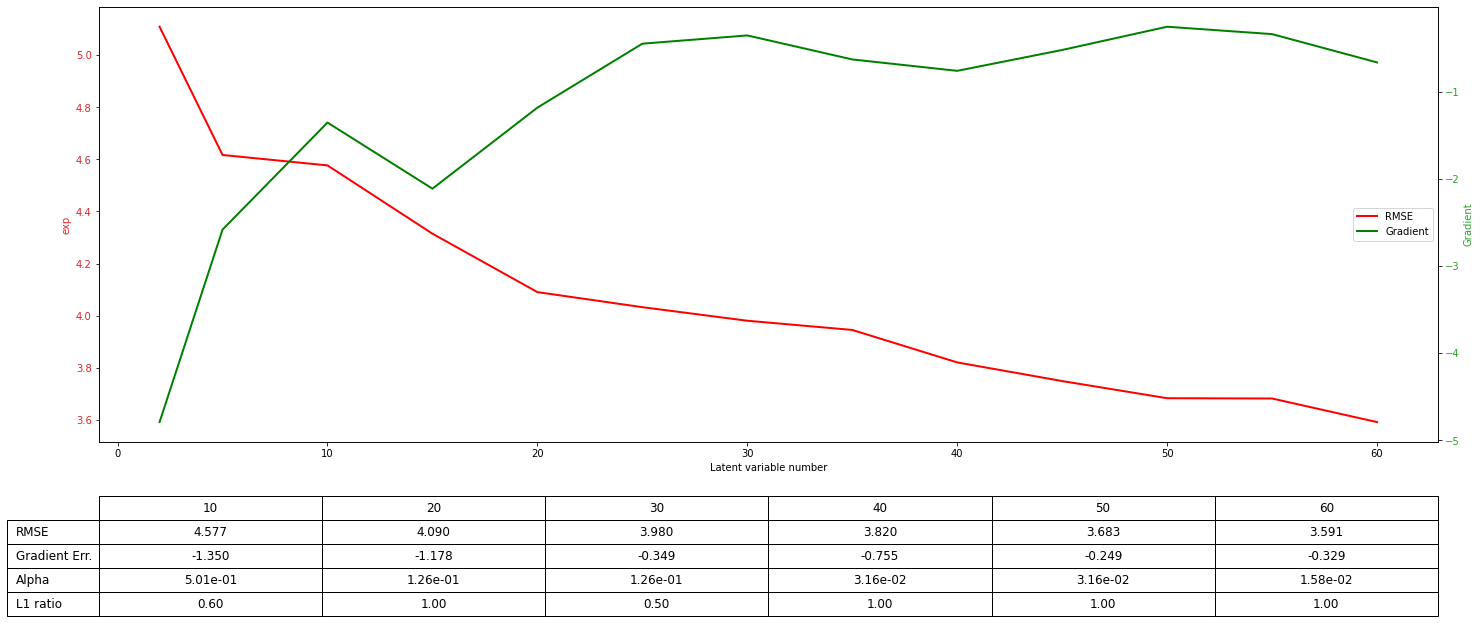

In [19]:
fig, ax1 = plt.subplots(figsize=(24, 8))

color = 'tab:red'
ax1.set_ylabel('exp', color=color)
ax1.tick_params(axis='y', labelcolor=color)
err=ax1.plot(components, np.array(rmsecv)**.5, '-', linewidth=2, label='RMSE', color='red')

color = 'tab:green'
ax2 = ax1.twinx()
grad=ax2.plot(components, np.gradient(rmsecv), '-', linewidth=2, label='Gradient', color='green')
ax2.set_ylabel('Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# added these three lines
lns = err+grad
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=5)

ax1.set_xlabel('Latent variable number') #,labelpad=40

steps = 10

simp_alpha = []
simp_l1 = []
simp_comp = []
simp_rmsecv = []
gradient = savgol_filter(rmsecv, window_length=3, polyorder=2, deriv=1, mode='nearest')
simp_gradient = []

for index, (comp, alpha, l1, rm, gr) in enumerate(zip(components, alpha_opt, l1_ratio_opt, rmsecv, gradient)):    
    if (comp)%steps == 0:
        simp_alpha.append('{:.2e}'.format(alpha))
        simp_l1.append('{:.2f}'.format(l1))
        simp_comp.append('{}'.format(int(comp)))
        simp_rmsecv.append('{:.3f}'.format(np.sqrt(rm)))
        simp_gradient.append('{:.3f}'.format(gr))


the_table = plt.table(cellText=[simp_rmsecv, simp_gradient, simp_alpha,simp_l1], rowLabels=['RMSE', 'Gradient Err.', 'Alpha', 'L1 ratio'],
                      colLabels=simp_comp,
                      colLoc='center',
                      loc='bottom',
                      cellLoc='center',
                      bbox=[0, -.4, 1, 0.275])

the_table.auto_set_font_size(True)
the_table.set_fontsize(12)

#plt.xticks(components, components)
plt.grid(axis='x', which='both')
plt.savefig('Elastic Net - components - RMSECV.png', bbox_inches='tight')
plt.show()

In [20]:
### !pip install hyperopt

In [21]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import r2_score

In [22]:
counter = 0
bestscore = 1e20

#pipe1.set_params(savgol__window_length=9)
#Xtrans = pipe1.fit_transform(spectra)

def objective(params):
    #print(params)
    global counter
    global bestscore
    counter += 1
    
    hyperparams = {
        'alpha': params['alpha'],
        'l1_ratio': params['l1_ratio'],
        'random_state': 0,
        }
    
    pipe1.set_params(pca__n_components=int(params['pca__n_components']))
    pipe1.set_params(savgol__window_length=int(params['savgol__window_length'])+1)
    pipe1.set_params(savgol__deriv=int(params['savgol__deriv']))
    pipe1.set_params(savgol__wavemin=int(params['savgol__wavemin']))
    pipe1.set_params(savgol__wavemax=int(params['savgol__wavemax']))
    pipe1.set_params(savgol__polyorder=int(params['savgol__polyorder']))
    
    Xtrans = pipe1.fit_transform(X_train)
    
    elnet = ElasticNet(**hyperparams)
    
    preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf, n_jobs=-2)
    score = mean_squared_error(y_train , preds)
    #score = -r2_score(spectra['target'] , preds)
    
    #score = -cross_val_score(regpip, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-2).mean()
    if counter % 25 == 0:
        print("{} - MSECV {}".format(counter, score))
        #print(params)
    if score < bestscore:
        bestscore = score
        print("{} - MSECV {} - {}".format(counter, score, params))
    
    return score

space = {
    'alpha': hp.loguniform('alpha', -3, 0),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
    'pca__n_components': 5,
    'savgol__window_length': hp.quniform('savgol__window_length', 3, 19, 2),
    'savgol__deriv':hp.quniform('savgol__deriv', 1, 2, 1),
    'savgol__wavemin': hp.quniform('savgol__wavemin', 950, 1200, 2),
    'savgol__wavemax': hp.quniform('savgol__wavemax', 1300, 1530, 2),
    'savgol__polyorder':hp.quniform('savgol__polyorder', 2, 3, 1)
    
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500)

1 - MSECV 21.106378392747327 - {'alpha': 0.07116046007222084, 'l1_ratio': 0.15213118136385595, 'pca__n_components': 5, 'savgol__deriv': 1.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1504.0, 'savgol__wavemin': 1102.0, 'savgol__window_length': 14.0}
2 - MSECV 20.040505746695754 - {'alpha': 0.07133546030524567, 'l1_ratio': 0.4140564317290397, 'pca__n_components': 5, 'savgol__deriv': 1.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1404.0, 'savgol__wavemin': 1046.0, 'savgol__window_length': 18.0}
22 - MSECV 20.01730560886723 - {'alpha': 0.11979882812170496, 'l1_ratio': 0.893895111984131, 'pca__n_components': 5, 'savgol__deriv': 1.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1394.0, 'savgol__wavemin': 952.0, 'savgol__window_length': 18.0}
23 - MSECV 20.015786762867915 - {'alpha': 0.12331442219822097, 'l1_ratio': 0.9145065877611931, 'pca__n_components': 5, 'savgol__deriv': 1.0, 'savgol__polyorder': 2.0, 'savgol__wavemax': 1330.0, 'savgol__wavemin': 964.0, 'savgol__window_length': 18.

In [23]:
best

{'alpha': 0.25201401279473806,
 'l1_ratio': 0.9998501045796317,
 'savgol__deriv': 1.0,
 'savgol__polyorder': 2.0,
 'savgol__wavemax': 1422.0,
 'savgol__wavemin': 1046.0,
 'savgol__window_length': 18.0}

In [24]:
params = {
        'alpha': best['alpha'],
        'l1_ratio': best['l1_ratio'],
        'random_state': 0,
        }

elnet = ElasticNet(**params)

params

{'alpha': 0.25201401279473806,
 'l1_ratio': 0.9998501045796317,
 'random_state': 0}

In [26]:
pipe1.set_params(pca__n_components=5)
pipe1.set_params(savgol__window_length=int(best['savgol__window_length'])+1)
pipe1.set_params(savgol__deriv=int(best['savgol__deriv']))
pipe1.set_params(savgol__wavemin=int(best['savgol__wavemin']))
pipe1.set_params(savgol__wavemax=int(best['savgol__wavemax']))
pipe1.set_params(savgol__polyorder=int(best['savgol__polyorder']))
pipe1.fit(X_train)
Xtrans = pipe1.transform(X_train)

In [27]:
preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf)
mean_squared_error(preds, y_train)

19.98494635582148

In [28]:
mean_squared_error(preds, y_train)**.5

4.470452589595541

In [29]:
Xtrans = pipe1.fit_transform(X_train)
Xtrans.shape

(677, 5)

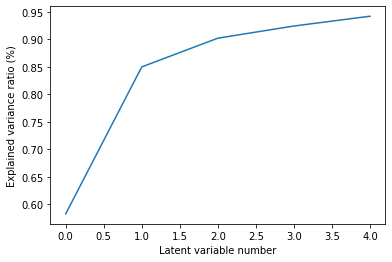

In [30]:
exp_variance_ratio_ = pipe1.named_steps['pca'].explained_variance_ratio_
cumsum=np.cumsum(exp_variance_ratio_)

plt.plot(range(cumsum.shape[0]), cumsum)
# Axis
#plt.plot([-40, 40], [0, 0], color='black', ls='--')
#plt.plot([0, 0], [-14, 14], color='black', ls='--')
# Title
#plt.title('Cumulative sum - explained variance ratio')
plt.xlabel('Latent variable number')
plt.ylabel('Explained variance ratio (%)')
plt.savefig('elnet - pca latent variable.png', bbox_inches = 'tight')
plt.show()

In [31]:
cumsum

array([0.58275718, 0.84988138, 0.90206464, 0.9241539 , 0.94190512])

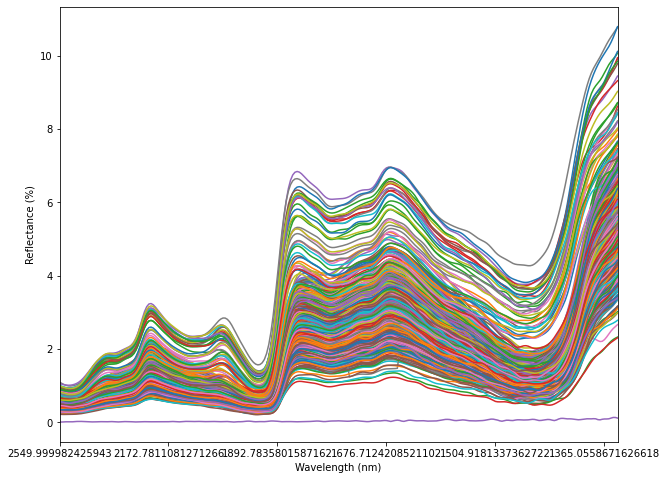

In [32]:
colnames = X.columns
df = X[colnames].T
df.plot(legend=False, figsize=(10,8))
#plt.title('Spectras')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.savefig('elnet-Spectras-ElasticnetcleaningE.png', bbox_inches = 'tight')
plt.show()

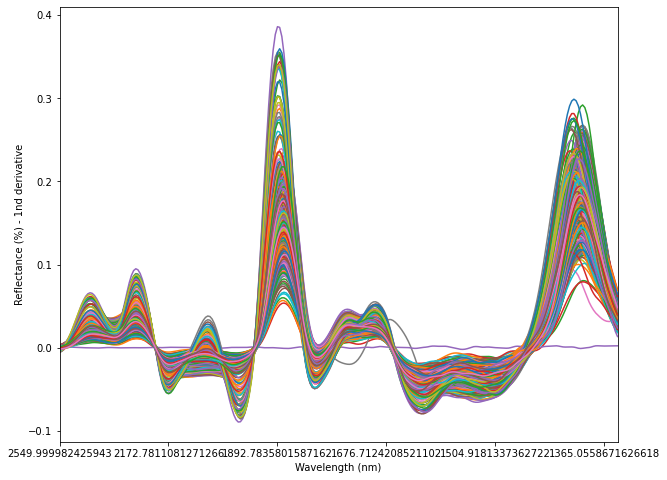

In [33]:
params={'window_length':int(best['savgol__window_length'])+1,
        'polyorder':int(best['savgol__polyorder']),
        'deriv':int(best['savgol__deriv']),
        'wavemin':int(best['savgol__wavemin']),
        'wavemax':int(best['savgol__wavemax'])}
savgol = Savgol(**params)

#colnames = [str(x) for x in range(int(best['savgol__wavemin']), int(best['savgol__wavemax'])+1,2)]
df = savgol.fit_transform(X).T
df.plot(legend=False, figsize=(10,8))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%) - {}nd derivative'.format(int(best['savgol__deriv'])))

plt.savefig('elnet-Spectras-savgol-Elasticnetcleaning2ndderivativeE.png', bbox_inches = 'tight')
plt.show()

In [34]:
preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf)
mean_squared_error(preds, y_train)

19.984946346760566

In [35]:
alpha_range = np.logspace(-3, 0, 11)
l1_ratio_range = np.linspace(0.0001, 1, 11)
param_grid = dict(alpha=alpha_range, l1_ratio=l1_ratio_range)

elnet = ElasticNet(random_state=0, max_iter=10000)

gridrmse = GridSearchCV(elnet, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='neg_mean_squared_error') #'neg_mean_squared_error'
gridrmse.fit(Xtrans, y_train)

/home/william/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=False),
             error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=10000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-2,
             param_grid={'alpha': array([0.001     , 0.00199526, 0.00398107, 0.00794328, 0.01584893,
       0.03162278, 0.06309573, 0.12589254, 0.25118864, 0.50118723,
       1.        ]),
                         'l1_ratio': array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
       5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
       1.0000e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_

In [36]:
gridrmse.best_params_

{'alpha': 0.25118864315095796, 'l1_ratio': 1.0}

In [37]:
gridrmse.best_score_

-19.984948389535628

In [38]:
scores = gridrmse.cv_results_['mean_test_score'].reshape(len(l1_ratio_range),len(alpha_range))

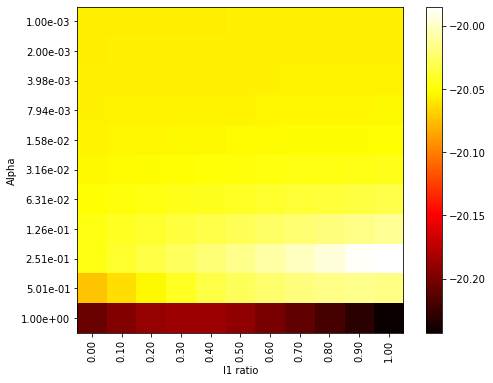

In [39]:
# heat map
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,)
plt.ylabel('Alpha')
plt.xlabel('l1 ratio')
cb = plt.colorbar()#.set_params(fontname="Times New Roman", fontsize=18)
plt.yticks(np.arange(len(alpha_range)), ['{:.2e}'.format(x) for x in alpha_range])
plt.xticks(np.arange(len(l1_ratio_range)), ['{:.2f}'.format(x) for x in l1_ratio_range], rotation=90)
#plt.yticks(fontname="Times New Roman", fontsize=18)
#plt.xticks(fontname="Times New Roman", fontsize=18)
plt.savefig('elnet - elasticnet sensitivity.png', bbox_inches = 'tight')
plt.show()

In [40]:
# RMSECV TRAIN SCORE
elnet = ElasticNet(random_state=0, max_iter=10000, **gridrmse.best_params_)
predsrmse = cross_val_predict(elnet, Xtrans, y_train, cv=kf)

(mean_squared_error(predsrmse, y_train))**.5

4.470452817057309

In [41]:
# RMSE TEST SCORE

#Fit with best parameters
Xtranstest = pipe1.transform(X_test)
elnet = ElasticNet(random_state=0, max_iter=10000, **gridrmse.best_params_)
elnet.fit(Xtrans, y_train)


# Prediction on test set
preds_test = elnet.predict(Xtranstest)
(mean_squared_error(preds_test, y_test))**.5

4.140707229884008

In [42]:
alpha_range = np.logspace(-3, 0, 11)
l1_ratio_range = np.linspace(0.0001, 1, 11)
param_grid = dict(alpha=alpha_range, l1_ratio=l1_ratio_range)

elnet = ElasticNet(random_state=0)

gridr2 = GridSearchCV(elnet, param_grid=param_grid, cv=kf, n_jobs=-2, scoring='r2') #'neg_mean_squared_error'
gridr2.fit(Xtrans, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=47, shuffle=False),
             error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-2,
             param_grid={'alpha': array([0.001     , 0.00199526, 0.00398107, 0.00794328, 0.01584893,
       0.03162278, 0.06309573, 0.12589254, 0.25118864, 0.50118723,
       1.        ]),
                         'l1_ratio': array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
       5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
       1.0000e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbo

In [43]:
gridr2.best_params_

{'alpha': 0.25118864315095796, 'l1_ratio': 1.0}

In [44]:
gridr2.best_score_

0.6887530118038273

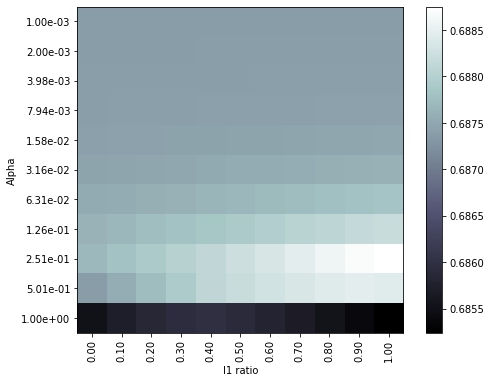

In [45]:
# heat map
scores = gridr2.cv_results_['mean_test_score'].reshape(len(l1_ratio_range),len(alpha_range))
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.bone,)
plt.ylabel('Alpha')
plt.xlabel('l1 ratio')
plt.colorbar()
plt.yticks(np.arange(len(alpha_range)), ['{:.2e}'.format(x) for x in alpha_range])
plt.xticks(np.arange(len(l1_ratio_range)), ['{:.2f}'.format(x) for x in l1_ratio_range], rotation=90)
plt.savefig('elnet - elasticnet sensitivity - R2.png', bbox_inches = 'tight')
plt.show()

In [46]:


# R2 CV train set

elnet = ElasticNet(random_state=0, max_iter=10000, **gridr2.best_params_)
predsr2 = cross_val_predict(elnet, Xtrans, y_train, cv=kf)
r2_score( y_train,predsr2 , )



0.694690492990659

In [47]:
# R2 CV test set

elnet = ElasticNet(random_state=0, max_iter=10000, **gridr2.best_params_)
#Fit with best parameters

Xtranstest = pipe1.transform(X_test)
elnet.fit(Xtrans, y_train)

predsr2 = elnet.predict(Xtranstest)
r2_score( y_test,predsr2 )

0.7536415392908762

In [48]:
# Generate test results

elnet = ElasticNet(random_state=0, max_iter=10000, **gridrmse.best_params_)

#Fit with best parameters
Xtrans = pipe1.fit_transform(X_train)
elnet.fit(Xtrans, y_train)


# Prediction on test set
Xtranstest = pipe1.transform(X_test)
preds_test = elnet.predict(Xtranstest)
(mean_squared_error(preds_test, y_test))**.5

4.1407072299396726

In [49]:
Xtranstrain = pipe1.transform(X_train)
preds_train = elnet.predict(Xtranstrain)
traindf = pd.DataFrame({'target':y_train, 'pred':preds_train, 'validation':[0 for x in range(y_train.shape[0])]})
#df = pd.concat([df, traindf])
#df.head()

In [50]:
df = pd.DataFrame({'target':y_test, 'pred':preds_test, 'validation':[1 for x in range(y_test.shape[0])]})
df['delta'] = df['target'] - df['pred']
df['deltaabs'] = np.abs(df['delta'])
df.head()

,target,pred,validation,delta,deltaabs
457,44.7,47.667873,1,-2.967873,2.967873
342,53.9,46.735692,1,7.164308,7.164308
280,43.1,44.381204,1,-1.281204,1.281204
275,47.9,53.809785,1,-5.909785,5.909785
843,38.1,39.328398,1,-1.228398,1.228398


In [51]:
df[['delta']].describe()

,delta
count,170.000000
mean,-0.829908
std,4.068671
min,-8.801425
25%,-3.579096
50%,-1.159657
75%,2.111925
max,9.427851


In [52]:
df.sort_values('delta', ascending=False).head()

,target,pred,validation,delta,deltaabs
139,56.1,46.672149,1,9.427851,9.427851
323,57.2,49.319760,1,7.880240,7.880240
192,52.9,45.672026,1,7.227974,7.227974
342,53.9,46.735692,1,7.164308,7.164308
266,67.0,60.004227,1,6.995773,6.995773


In [53]:
print('UNcleaned RMSE', (mean_squared_error(df['target'], df['pred']))**.5)
print('UNcleaned R2', r2_score(df['target'], df['pred']))
    
if False:
    print()
    subset = df.drop([72, 73, 75])
    print('cleaned RMSE', (mean_squared_error(subset['target'], subset['pred']))**.5)
    print('cleaned R2', r2_score(subset['target'], subset['pred']))

UNcleaned RMSE 4.1407072299396726
UNcleaned R2 0.7536415392842524


/home/william/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


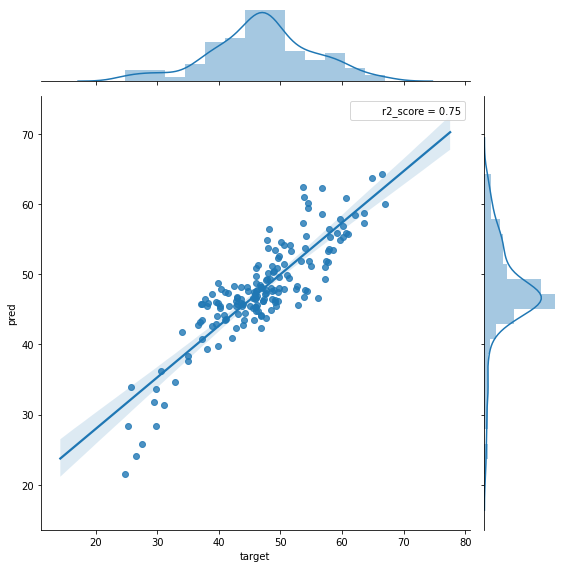

In [54]:
import seaborn as sns


from scipy import stats
from sklearn.metrics import r2_score

#fig, ax = plt.subplots()

sns.jointplot(x='target', y='pred', data=df[df['validation']==1],  height=8, stat_func=r2_score, kind='reg')
#sns.jointplot(x='target', y='pred', data=df[df['validation']==0],  height=8, stat_func=r2_score, kind='reg', ax=ax, label='train', color='r')
#plt.xlabel('Actual tenderometer reading')
#plt.ylabel('Predicted tenderometer reading')
#ax.legend()
plt.savefig('elnet - result regression.png', bbox_inches = 'tight')
plt.show()

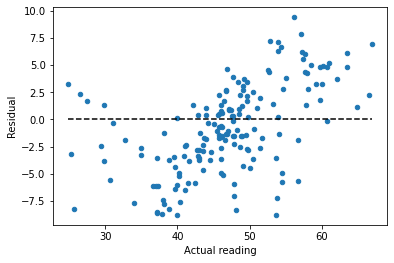

,delta
count,170.000000
mean,-0.829908
std,4.068671
min,-8.801425
25%,-3.579096
50%,-1.159657
75%,2.111925
max,9.427851


In [55]:
df.plot.scatter('target', 'delta')
plt.plot([df['target'].min(), df['target'].max()], [0, 0], color='k', linestyle='--')
#plt.title('Delta error ')
plt.xlabel('Actual reading')
plt.ylabel('Residual')
plt.savefig('elnet-residualE.png', bbox_inches = 'tight')
plt.show()
df[['delta']].describe()

In [56]:
best

{'alpha': 0.25201401279473806,
 'l1_ratio': 0.9998501045796317,
 'savgol__deriv': 1.0,
 'savgol__polyorder': 2.0,
 'savgol__wavemax': 1422.0,
 'savgol__wavemin': 1046.0,
 'savgol__window_length': 18.0}

In [57]:
params = best
params = {**params, **gridr2.best_params_}
params = {**params, 'RMSE train':mean_squared_error(y_train, predsrmse)**.5, 'R2 train':r2_score(y_train, predsrmse)}
params = {**params, 'RMSE test':mean_squared_error(y_test, preds_test)**.5, 'R2 test':r2_score(y_test, preds_test)}
params

{'alpha': 0.25118864315095796,
 'l1_ratio': 1.0,
 'savgol__deriv': 1.0,
 'savgol__polyorder': 2.0,
 'savgol__wavemax': 1422.0,
 'savgol__wavemin': 1046.0,
 'savgol__window_length': 18.0,
 'RMSE train': 4.470452817057309,
 'R2 train': 0.694690492990659,
 'RMSE test': 4.1407072299396726,
 'R2 test': 0.7536415392842524}

In [58]:
samplesize = df.shape[0]
print('sample size:', samplesize)

for errorabs in [1 ,2 ,3 ,4 ,6 ,8, 10]:
    correctcount = df[df['deltaabs'] < errorabs].shape[0]
    percent = correctcount/samplesize
    print('prediction +/- {:.1f} : percent {:05.02f} %'.format(errorabs, percent*100))
    params = {**params, 'preds +/-{}'.format(int(errorabs)):percent}

sample size: 170
prediction +/- 1.0 : percent 15.29 %
prediction +/- 2.0 : percent 36.47 %
prediction +/- 3.0 : percent 51.76 %
prediction +/- 4.0 : percent 66.47 %
prediction +/- 6.0 : percent 82.35 %
prediction +/- 8.0 : percent 94.71 %
prediction +/- 10.0 : percent 100.00 %


In [59]:
resultset = pd.DataFrame(params, index=['elnet'])
resultset.to_csv('res_elnetE.csv')
resultset.T

,elnet
alpha,0.251189
l1_ratio,1.000000
savgol__deriv,1.000000
savgol__polyorder,2.000000
savgol__wavemax,1422.000000
savgol__wavemin,1046.000000
savgol__window_length,18.000000
RMSE train,4.470453
R2 train,0.694690
RMSE test,4.140707
